In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
#!pip install pip install distfit

In [3]:
from PIL import Image
from itertools import product
import os
def tile(filename, dir_in, dir_out):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    #image = img.copy()
    # Draw a rectangle with red borders and thickness of 5 px
    #image = cv2.rectangle(image, top_left, bottom_right, colour, thickness)
    probable = list(range(32,72,2))
    dim = []
    for i in probable:
        #print(i)
        if(w*h)%i == 0:
            dim.append(i)
    d = dim[int(len(dim)/2)]
    print(d)
    #row, col = img_n.shape
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    #std = []
    # Set the line color to red in BGR
    colour = (255, 255, 255)

    # Set line thickness to 5px
    thickness = 2
    left = [] 
    upper=[]
    right =[]
    lower = []
    mean = []
    inc = 0
    for i, j in grid:
        box = (j, i, j+d, i+d)
        left.append(j)
        upper.append(i)
        right.append(j+d)
        lower.append(i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        #std.append(img.crop(box).std())
        mean.append(np.mean(img.crop(box)))
        img.crop(box).save(out)
        inc = inc + 1
        
    return left,upper,right,lower, mean

In [4]:
def selectROI(left,upper,right,lower, mean):
    #target between medium and high mean
    #remove low mean
    medium_mean = int(np.fix((max(mean)+min(mean))/2))
    high_mean  = int(max(mean))
    selected_values = list(x for x in mean if medium_mean < x < high_mean-1)
    #print(np.mean(selected_values))
    #print(selected_values)
    #value_select = list(x for x in selected_values if int(np.fix(x)) == int(np.fix(np.mean(selected_values))))
    #list(x for x in value_select if medium_mean <= x < high_mean)
    #if len(selected_values) > 5:
    while len(selected_values) >= 15:
        selected_values = list(x for x in selected_values if (np.mean(selected_values)) < x < (np.max(selected_values)))
        #print(selected_values)
    #value_select = list(x for x in value_select if (np.mean(value_select)) < x < (np.max(value_select)-1))
    #value_select = list(x for x in value_select if (np.mean(value_select)) < x < (np.max(value_select)-1))
    
    #print(selected_values)
    lefts = []
    uppers = []
    rights = []
    lowers = []
    for i in selected_values:
        index = mean.index(i)
        lefts.append(left[index])
        uppers.append(upper[index])
        rights.append(right[index])
        lowers.append(lower[index])
    #elif len(value_select) >1 and len(value_select) != 0:
    #    indexes = list(x for x in mean.index(np.mean(value_select)))
    #    left = list(x for x in left[indexes])
    #    upper  = list(x for x in upper[indexes])
    #    right  = list(x for x in right[indexes])
    #    lower  = list(x for x in lower[indexes])
   
    return lefts,uppers,rights,lowers
    

In [5]:
def estimate_noise_std(img, average=True):
    """Estimate standard deviation of noise in ``img``.

    The algorithm, given in [Immerkaer1996], estimates the noise in an image.

    Parameters
    ----------
    img : array-like
        Array to estimate noise in.
    average : bool
        If ``True``, return the mean noise in the image, otherwise give a
        pointwise estimate.

    Returns
    -------
    noise : float

    Examples
    --------
    Create image with noise 1.0, verify result

    >>> img = np.random.randn(10, 10)
    >>> result = estimate_noise_std(img)  # should be about 1

    Also works with higher dimensional arrays

    >>> img = np.random.randn(3, 3, 3)
    >>> result = estimate_noise_std(img)

    The method can also estimate the noise pointwise (but with high
    uncertainity):

    >>> img = np.random.randn(3, 3, 3)
    >>> result = estimate_noise_std(img, average=False)

    References
    ----------
    [Immerkaer1996] Immerkaer, J. *Fast Noise Variance Estimation*.
    Computer Vision and Image Understanding, 1996.
    """
    import scipy.signal
    import functools
    img = np.asarray(img, dtype='float')

    M = functools.reduce(np.add.outer, [[-1, 2, -1]] * img.ndim)

    convolved = scipy.signal.fftconvolve(img, M, mode='valid')
    if average:
        conv_var = np.sum(convolved ** 2) / convolved.size
    else:
        conv_var = convolved ** 2

        # Pad in order to retain shape
        conv_var = np.pad(conv_var, pad_width=1, mode='edge')

    scale = np.sum(np.square(M))
    sigma = np.sqrt(conv_var / scale)

    return sigma 

In [6]:
def visualize_the_ROI(filename,left_select,upper_select,right_select,lower_select,out):
    img = cv2.imread(filename,0)
    row, col = img.shape
    #gauss = np.random.normal(10,10,(row,col))
    #noisy = img + gauss
    smooth_parts = []
    #(left, upper, right, lower) (0, 0, 70, 70)
    # Set the coordinates of top left corner of rectangle
    #(910, 630, 980, 700)(896, 640, 960, 704) (832, 512, 896, 576) (960, 704, 1024, 768) (704, 512, 768, 576)(832, 64, 896, 128)
    #(192, 64, 256, 128) (0, 128, 64, 192) (0, 576, 64, 640)
    for i in range(0,len(left_select)):
        top_left = (left_select[i], upper_select[i])

        #cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2) 
        #roi_image = gray[y:y+h, x:x+w]
        # Set the coordinates of bottom right corner of rectangle
        bottom_right = (right_select[i], lower_select[i])

        # Set the line color to red in BGR
        colour = (255, 255, 255)

        # Set line thickness to 5px
        thickness = 5

        image = img.copy()
        # Draw a rectangle with red borders and thickness of 5 px
        image = cv2.rectangle(image, top_left, bottom_right, colour, thickness)


        smooth_part = img[upper_select[i]:lower_select[i],left_select[i]:right_select[i]]
        smooth_parts.append(smooth_part)
        #histogram, bin_edges = np.histogram(img, bins=256, range=(0, 1))
        # Create figure and axes
        fig = plt.figure(figsize =(10, 7))
        plt.title('Selected ROI : ' + str(i))
        plt.subplot(221),plt.imshow(image,cmap = 'gray')
        plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222),plt.imshow(smooth_part,cmap = 'gray')
        plt.title('Region of Interest - ROI (probability)'), plt.xticks([]), plt.yticks([])
        plt.subplot(223),

        n, bins, patches = plt.hist(img.ravel(),256,[0,256])#; plt.show()
        #plt.title('Histogram - STD : ' + str(round(estimate_noise_std(img),2)) ), 
        plt.ylabel('Pixel count')
        plt.xlabel('Color level')
        #plt.text(150, 7250, r'$\sigma='+str(round(estimate_noise_std(img),2))+'$')
        plt.grid(True)
        plt.colorbar(orientation='horizontal')
        plt.clim(0, 256) 
        plt.subplot(224)#,plt.hist(smooth_part.ravel(),256,[0,256])#; plt.show()
        n, bins, patches = plt.hist(smooth_part.ravel(),256,[0,256])#; plt.show()
        #plt.title('Histogram - STD : ' + str(round(estimate_noise_std(smooth_part),2)) ), 
        plt.ylabel('Pixel count')
        plt.xlabel('Color level')
        #plt.text(180, 65, r'$\sigma='+str(round(estimate_noise_std(smooth_part),2))+'$')
        plt.grid(True)
        plt.colorbar(orientation='horizontal')
        plt.clim(0, 256) 
        plt.tight_layout()
        plt.savefig(os.path.splitext(out)[0]+'_'+str(i)+'.png', dpi=300)
        plt.show()
    return smooth_parts

In [7]:
from scipy.stats import poisson

# gaussian to use with array (numpy)
def gaussianfunc(x, mean, sigma):
    a = sigma*np.sqrt(2*np.pi)
    b = np.power((x-mean), 2.0)/(2*np.power(sigma, 2.0))
    return (1/a)*np.exp(-b)
    
# poisson to use with array (numpy) ADJUST THE VALUE

#calculate probability
def poissonfunc(k,mu):
    return poisson.pmf(k, mu)
    
    
# Model of gaussian noise by robust fitting without ROI
# works well for truncated histogram: if there is saturation !!!
def computemodelgaussiannoise0(src):
    #sel = selectregion(src)
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    sigma = np.max(a)*np.sqrt(2*np.pi)
    sigma = 1/sigma
    mean = np.where(a == np.max(a))[0][0]
    return mean, sigma
 
    
    # Model of poisson noise by robust fitting without ROI
# works well for truncated histogram: if there is saturation !!!
def computemodelpoisson0(src):
    #sel = selectregion(src)
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    mean = np.where(a == np.max(a))[0][0]
    sigma = np.sqrt(mean)
    return mean, sigma


In [8]:

# residual along with gaussian model
def computeresidualgaussian(src):
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    #a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    a = hist
    sigma = np.max(a)*np.sqrt(2*np.pi)
    sigma = 1/sigma
    mean = np.where(a == np.max(a))[0][0]
    residu = 0
    for i in range(1,254):
        residu = residu + (hist[i] - gaussianfunc(src, mean, sigma))**2
    return mean,sigma,residu
        

# residual along with poisson model
def computeresidualpoisson(src):
    hist1 = cv2.calcHist([src],[0],None,[256],[0,256])
    hist = hist1/src.size
    #a = cv2.blur(hist[1:255], (1,13)) #smoothing of histogram with value of 0 and 255 removed (saturation)
    a = hist
    mean = np.where(a == np.max(a))[0][0]
    sigma = np.sqrt(mean)
    residu = 0
    for x in range(1,254):
        residu = residu + (hist[x]-poissonfunc(src, mean))**2
    return mean,sigma,residu

# Segmentation and Noise Estimation Scan speed 01

48


/tmp/ipykernel_8874/1017964780.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221),plt.imshow(image,cmap = 'gray')


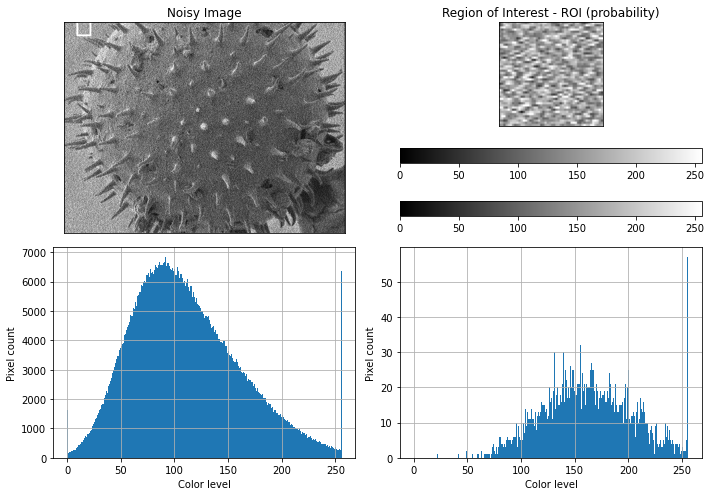

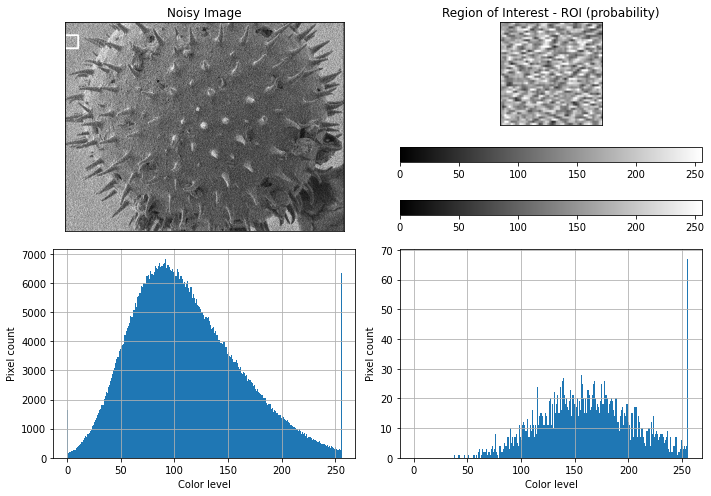

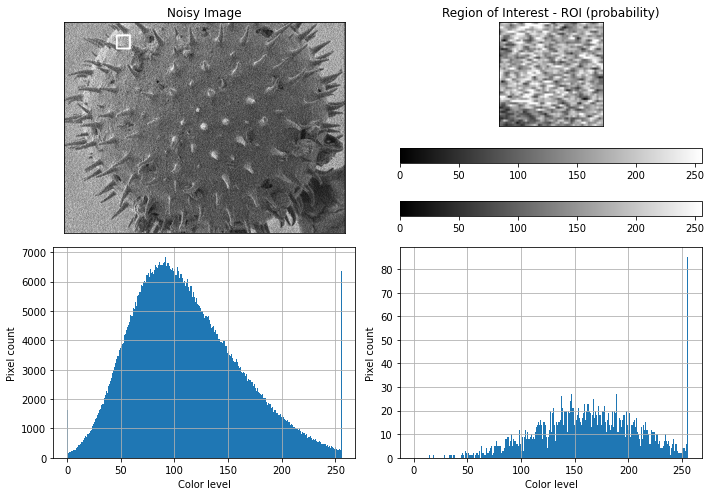

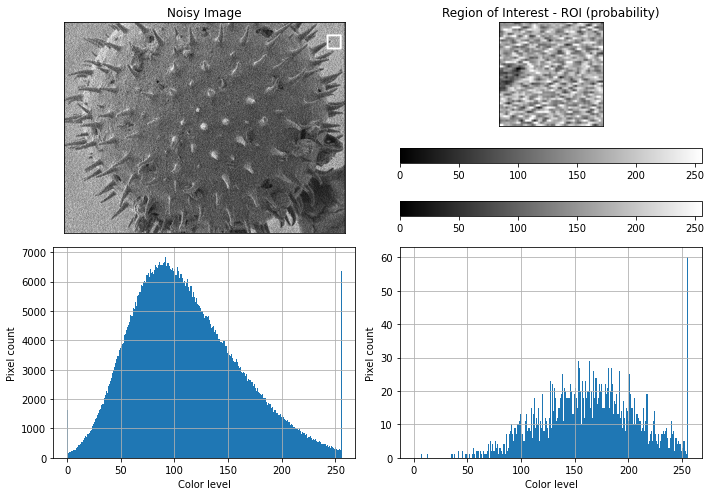

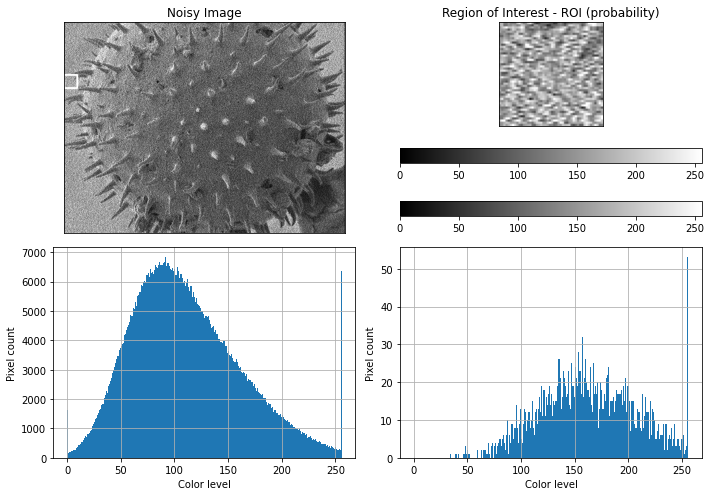

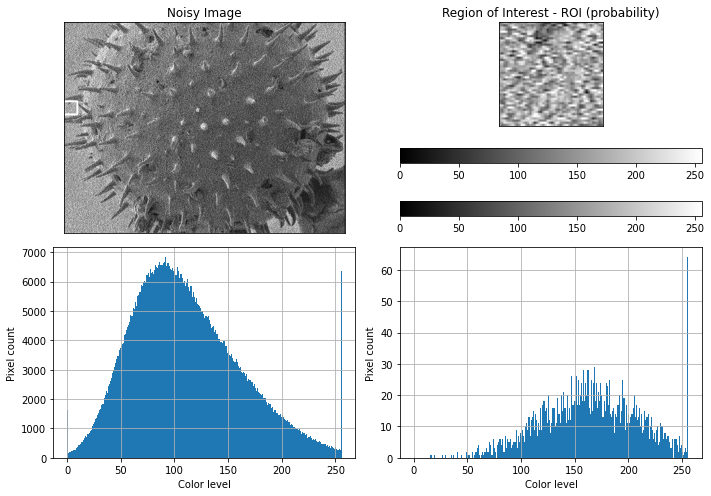

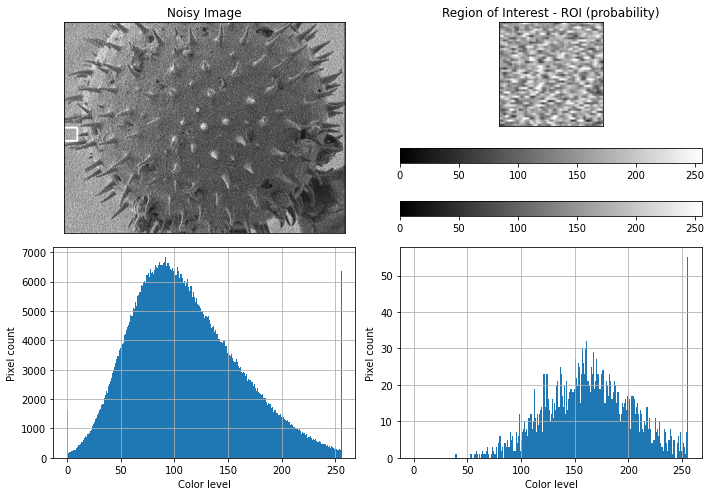

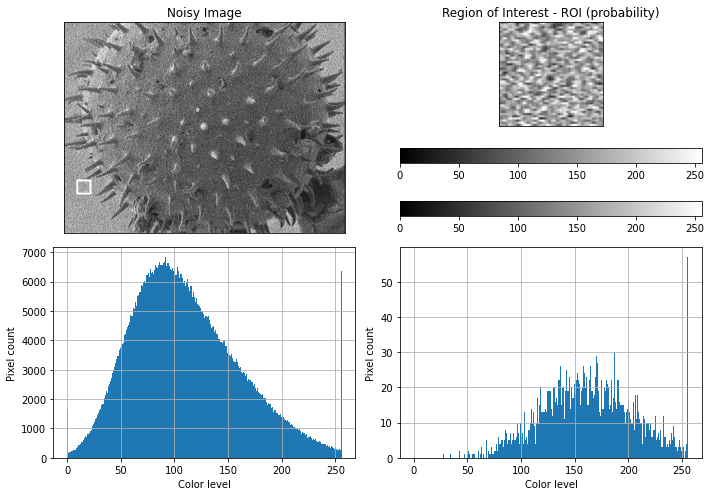

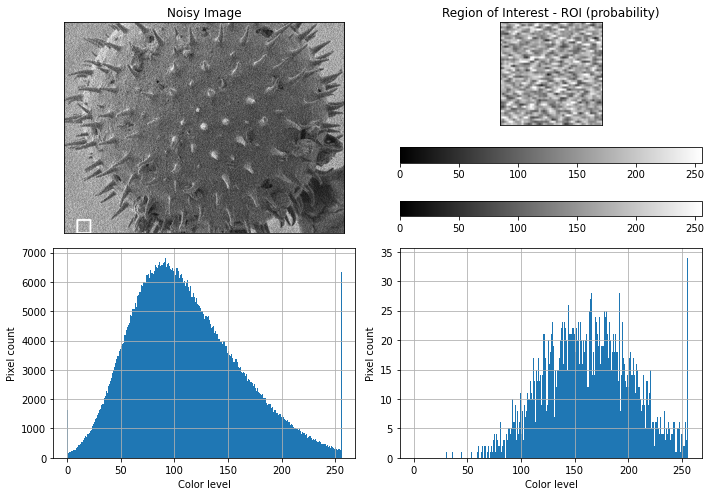

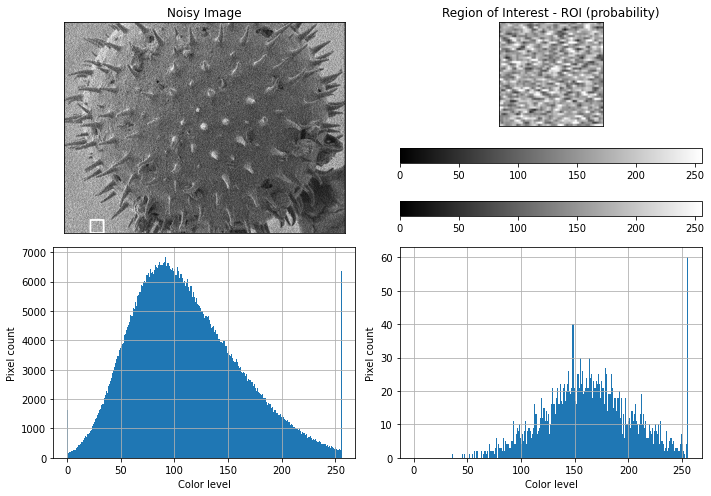

In [9]:
left,upper,right,lower, mean = tile('pollen.spd1.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd1.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd01.png')

Selected ROI is smooth_parts[2] . Lets check the histogram and statistical test to be the distribution is normal or gaussian as well as well the resudial calculation.

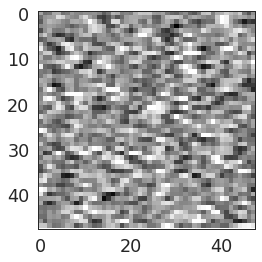

In [30]:
plt.imshow(smooth_parts[9],cmap='gray')

In [31]:
histg = cv2.calcHist([smooth_parts[9]],[0],None,[256],[0,256])

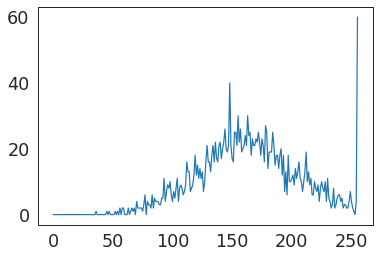

In [32]:
plt.plot(histg)
plt.show()

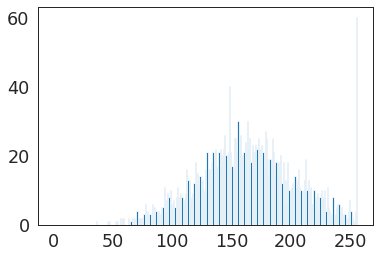

In [33]:
plt.hist(smooth_parts[9].ravel(),256,[0,256])
plt.show()

--> Anderson-Darling Test
Anderson-Darling Test is a statistical test that can be used to evaluate whether a data sample is in Standard Gaussian Distribution or not.The test is a improved version of nonparametric goodness-of-fit statistical test i.e. Kolmogorov-Smirnov test.
It can be used to check whether a data sample is normal. The test is a modified version of a more sophisticated nonparametric goodness-of-fit statistical test called the Kolmogorov-Smirnov test.
One of the features of Anderson-Darling test is that it returns list of critical value other than single p-value hence it provide us more insights on the final result.
The anderson() SciPy function implements the Anderson-Darling test. It takes as parameters the data sample and the name of the distribution to test it against. By default, the test will check against the Gaussian distribution (dist=’norm’)

In [14]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[8].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 1.474
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


Above code snippets return crtitcal values and statistic values on the sample data. But hold on.... Why we use critical values?

Critical values are basically range of pre-defined significance boundaries at which the H0 can be failed to be rejected if the calculated statistic is less than the critical value.So Anderson-Darling Test return critical values for different significance level instead of single p-value.
Results can be interpreted by failed Null Hypothesis if data is in normal distribution and test statistic value is less than the critical value at choosen significance level.

In [51]:
#!pip install pingouin smooth_parts[2][(smooth_parts[2] > 67) & (smooth_parts[2] < 247)]

Text(0.5, 1.0, 'Square Root Transformed Data')

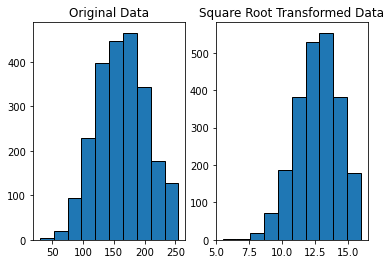

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(0)

#create beta distributed random variable with 200 values
data = smooth_parts[8].ravel()

#create log-transformed data
data_log = np.sqrt(data)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root Transformed Data')

In [16]:
import pingouin as pg
import seaborn as sns

/home/deepvision/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/deepvision/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [34]:
data = smooth_parts[9][(smooth_parts[9] > 67) & (smooth_parts[9] < 247)].ravel()

Text(0.5, 1.0, 'Square Root Data')

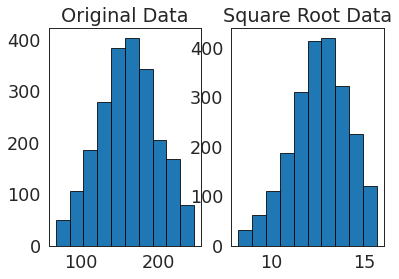

In [35]:
import numpy as np
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(0)

#create beta distributed random variable with 200 values
#data = smooth_parts[9].ravel()

#create log-transformed data
data_log = np.sqrt(data)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root Data')

In [19]:
from scipy import stats
k2, p = stats.normaltest(data)
#print(p)
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")

else:
    print("The null hypothesis cannot be rejected")
    
if stats.normaltest(np.log(np.flip(smooth_parts[8].ravel())), axis=0).pvalue < alpha:
    print("Not Log-norm")
    print(stats.normaltest(np.log(smooth_parts[8].ravel()), axis=0).pvalue)
else:
    #print(stats.normaltest(np.log(smooth_parts[9].ravel()), axis=0).pvalue)
    print("Log-normal")

p = 3.43738e-17
The null hypothesis can be rejected
Not Log-norm
4.055275957331719e-50


In [20]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
#data = np.log(smooth_parts[9].ravel())
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.992, p=0.000
Sample does not look Gaussian (reject H0)


In [21]:
from scipy.stats import normaltest
# generate univariate observations
#data = smooth_parts[9].ravel()
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=75.818, p=0.000
Sample does not look Gaussian (reject H0)


In [22]:
# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
#data = 5 * randn(100) + 50
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 2.790
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


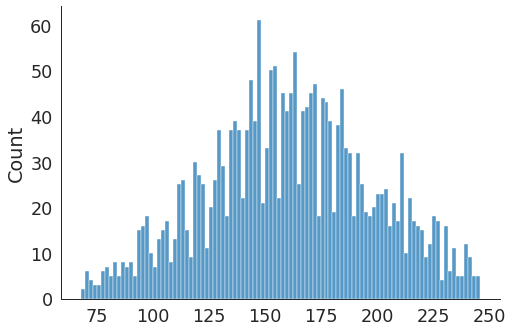

In [36]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=data, kind="hist", bins = 100, aspect = 1.5)

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:30<00:00,  6.11s/it]
burr was not fitted. no parameters available


sumsquare_error          aic           bic    kl_div  ks_statistic  \
gamma           0.000358  1104.106844 -3.441316e+04  0.056989      0.021746   
norm            0.000359  1101.927900 -3.441733e+04  0.056956      0.022148   
beta            0.000389  1093.612323 -3.422468e+04  0.059511      0.028478   
lognorm         0.017984  1355.419454 -2.578691e+04  2.897525      0.652932   
burr                 inf          inf           inf       inf           NaN   

         ks_pvalue  
gamma     0.244921  
norm      0.226630  
beta      0.055051  
lognorm   0.000000  
burr           NaN

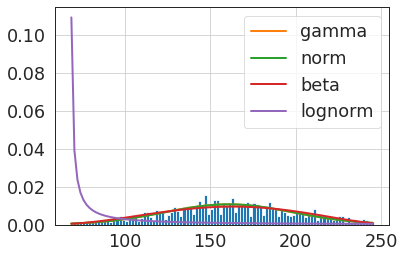

In [37]:
f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [38]:
f.get_best(method = 'sumsquare_error')

{'gamma': {'a': 4093.5179139069933,
  'loc': -2235.466726245273,
  'scale': 0.5854437266019885}}

In [27]:
f.fitted_param["beta"]

(2.437661108946572, 2.3060683397454946, 62.9784143205968, 188.93285065984122)

Fitting 10 distributions: 100%|█████████████████| 10/10 [00:30<00:00,  3.09s/it]


sumsquare_error          aic           bic    kl_div  ks_statistic  \
gamma            0.000358  1104.106844 -34413.160016  0.056989      0.021746   
norm             0.000359  1101.927900 -34417.327079  0.056956      0.022148   
chi2             0.000364  1105.471936 -34381.380134  0.058458      0.020554   
rayleigh         0.000521          inf -33597.154713  0.100783      0.068375   
cauchy           0.000624  1149.906422 -33200.489914  0.096705      0.085117   

             ks_pvalue  
gamma     2.449210e-01  
norm      2.266297e-01  
chi2      3.055794e-01  
rayleigh  2.122162e-09  
cauchy    2.467194e-14

/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


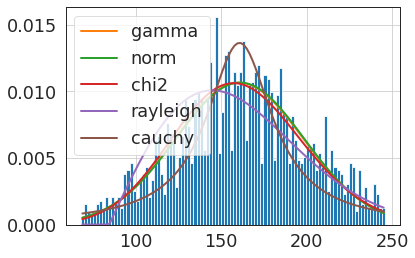

In [39]:
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [40]:
f.get_best(method = 'sumsquare_error')

{'gamma': {'a': 4093.5179139069933,
  'loc': -2235.466726245273,
  'scale': 0.5854437266019885}}

In [42]:
#get_distributions()

Fitting 106 distributions:  16%|██▍            | 17/106 [00:30<04:14,  2.85s/it]SKIPPED burr12 distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
SKIPPED crystalball distribution (taking more than 30 seconds)
Fitting 106 distributions:  67%|██████████     | 71/106 [01:29<01:11,  2.05s/it]SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitting 106 distributions:  75%|███████████▎   | 80/106 [01:40<00:46,  1.81s/it]SKIPPED ncf distribution (taking more than 30 seconds)
SKIPPED nct distribution (taking more than 30 seconds)
Fitting 106 distributions:  78%|███████████▋   | 83/106 [01:41<00:22,  1.03it/s]/home/deepvision/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in orde

sumsquare_error          aic           bic    kl_div  \
chi                   0.000358  1104.035791 -34414.137048  0.057070   
gamma                 0.000358  1104.106844 -34413.160016  0.056989   
genhyperbolic         0.000358  1108.239116 -34397.297268  0.057027   
erlang                0.000359  1104.210243 -34412.139834  0.057047   
exponnorm             0.000359  1103.927583 -34409.631785  0.056955   

               ks_statistic  ks_pvalue  
chi                0.021371   0.262998  
gamma              0.021746   0.244921  
genhyperbolic      0.021777   0.243483  
erlang             0.021934   0.236247  
exponnorm          0.022148   0.226624

/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


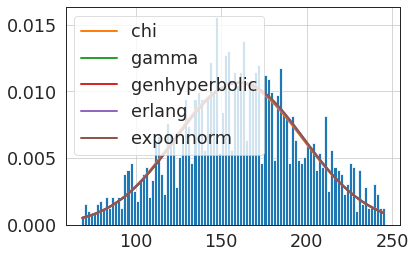

In [41]:
f = Fitter(data,
           distributions= get_distributions())
f.fit()
f.summary()

In [42]:
f.get_best(method = 'sumsquare_error')

{'chi': {'df': 101.5855251194887,
  'loc': -373.52204457905964,
  'scale': 53.159314840025615}}

In [45]:
from scipy.stats import gengamma

In [71]:
stats.normaltest(np.log(smooth_parts[9].ravel()), axis=0)

NormaltestResult(statistic=243.61406633137454, pvalue=1.2585707641772582e-53)

In [41]:
len(smooth_parts[9])

48

In [32]:
smooth_parts[9][(smooth_parts[9] > 67) & (smooth_parts[9] < 247)]

array([177, 134, 139, ..., 235, 245, 235], dtype=uint8)

In [31]:
pg.normality(smooth_parts[9][(smooth_parts[9] > 67) & (smooth_parts[9] < 247)].ravel(),method="jarque_bera")

W      pval  normal
0  20.364072  0.000038   False

In [34]:
#(df, alpha=.05)
pg.multivariate_normality(smooth_parts[9],alpha=.05)

HZResults(hz=192, pval=0.0, normal=False)

In [35]:
import scipy
from scipy.stats import lognorm

shape, location, scale = scipy.stats.lognorm.fit(smooth_parts[9][(smooth_parts[9] > 67) & (smooth_parts[9] < 247)].ravel())
mu, sigma = np.log(scale), shape

In [36]:
mu

1.3657411940562307

Many statistical tests make the assumption that datasets are normally distributed.

There are 2 common ways to check this assumption in Python:

# 1. (Visual Method) Create a histogram.

If the histogram is roughly “bell-shaped”, then the data is assumed to be normally distributed.

# 2. (Formal Statistical Test) Perform a Shapiro-Wilk Test.

If the p-value of the test is greater than α = .001, then the data is assumed to be normally distributed.



(array([ 18.,  31.,  43.,  64.,  78., 107., 119., 160., 207., 177., 210.,
        193., 183., 161., 105., 101.,  97.,  71.,  42.,  36.]),
 array([ 68. ,  76.9,  85.8,  94.7, 103.6, 112.5, 121.4, 130.3, 139.2,
        148.1, 157. , 165.9, 174.8, 183.7, 192.6, 201.5, 210.4, 219.3,
        228.2, 237.1, 246. ]),
 <BarContainer object of 20 artists>)

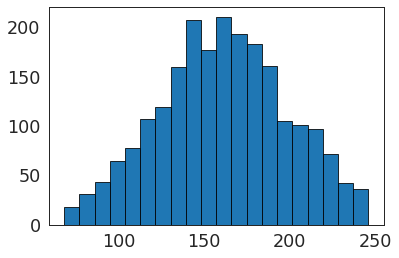

In [43]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(data.ravel(), edgecolor='black', bins=20)

By simply looking at this histogram, we can tell the dataset does not exhibit a “bell-shape” and is not normally distributed.

In [38]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[9][(smooth_parts[9] > 67) & (smooth_parts[9] < 247)].ravel())
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 4.72185e-08
The null hypothesis can be rejected


From the output we can see that the test statistic is 0.99 and the corresponding p-value is 2.8438714494427586e-08 (extremely close to zero).

Since the p-value is less than 0.001, we reject the null hypothesis of the Shapiro-Wilk test.

This means we have sufficient evidence to say that the sample data does not come from a normal distribution.

# Segmentation and Noise Estimation Scan speed 02

48


/tmp/ipykernel_8874/1017964780.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221),plt.imshow(image,cmap = 'gray')


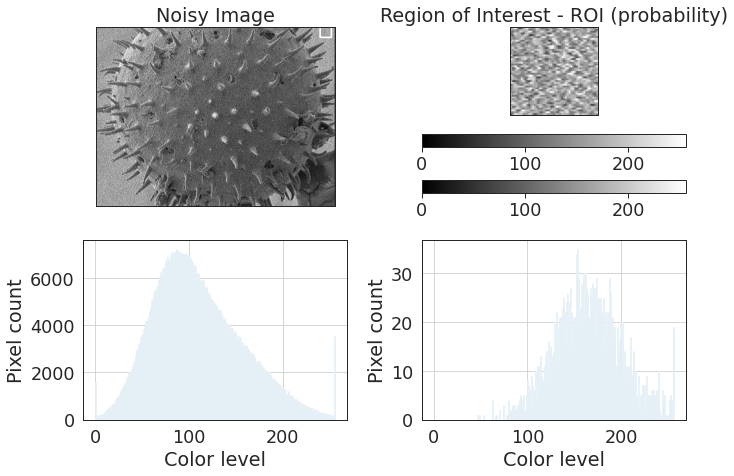

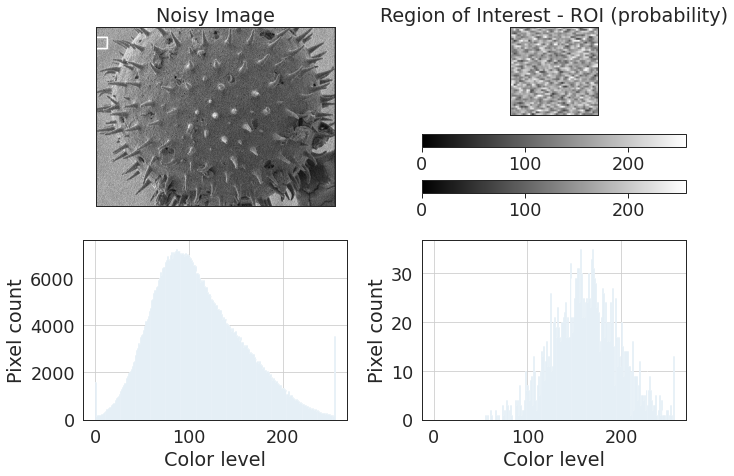

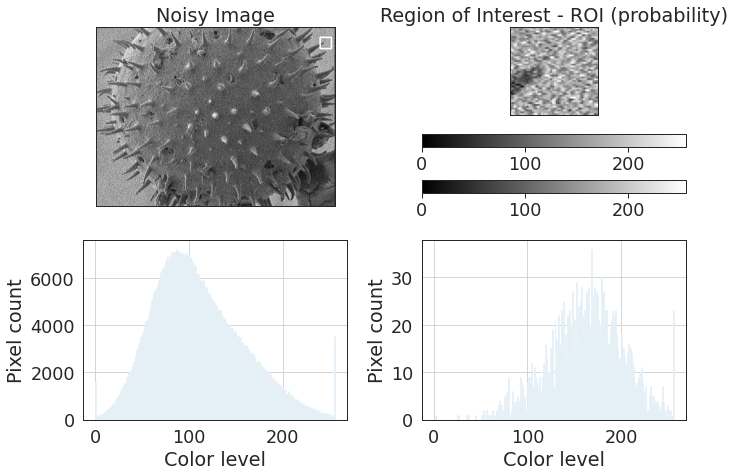

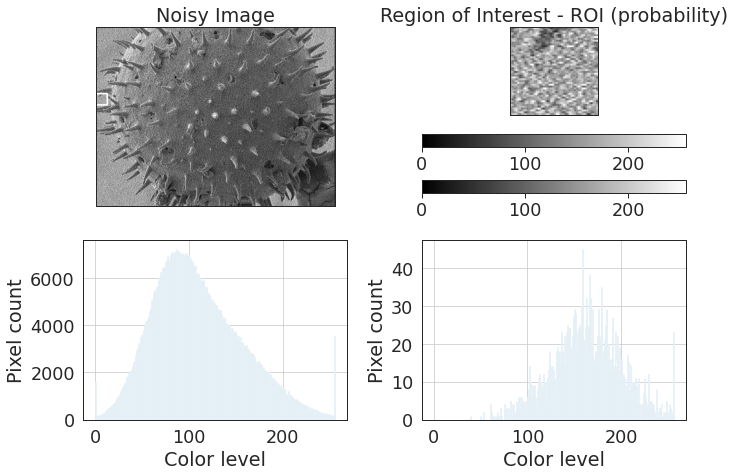

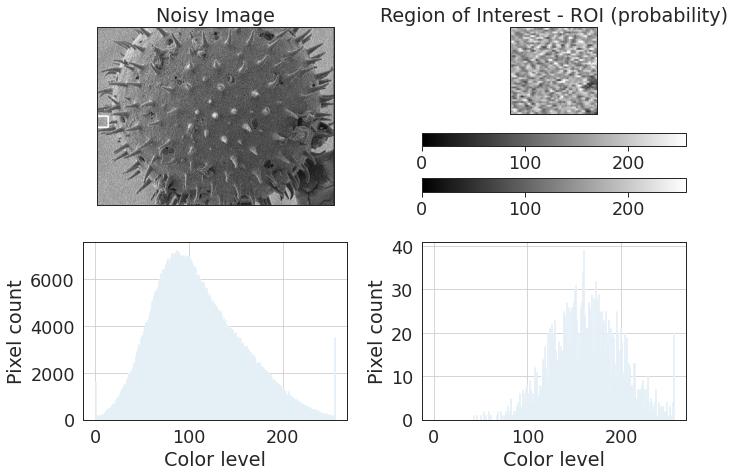

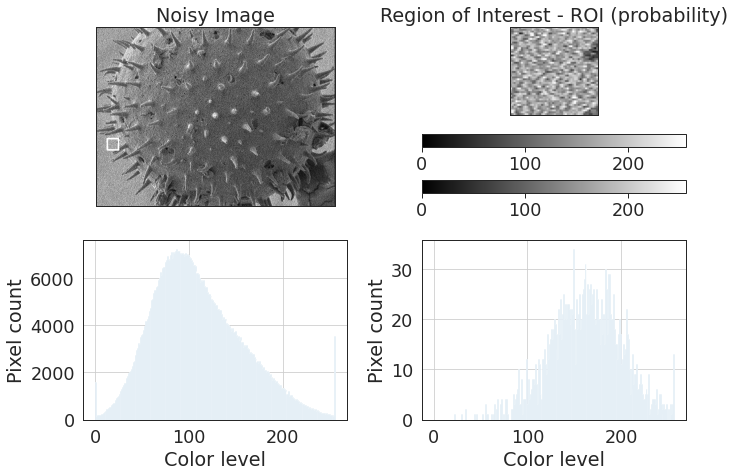

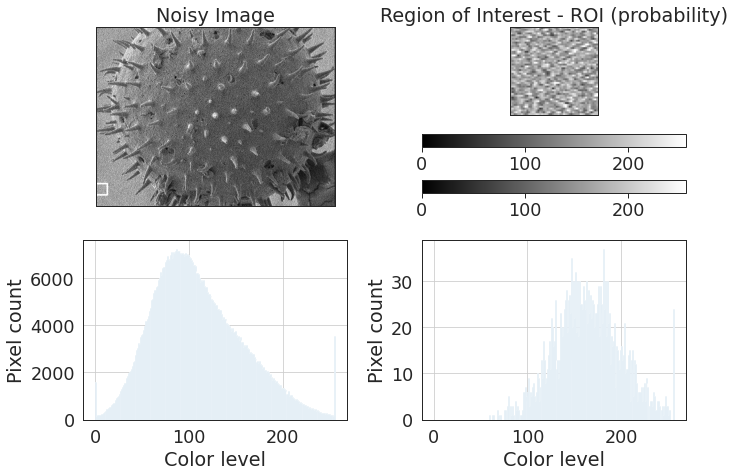

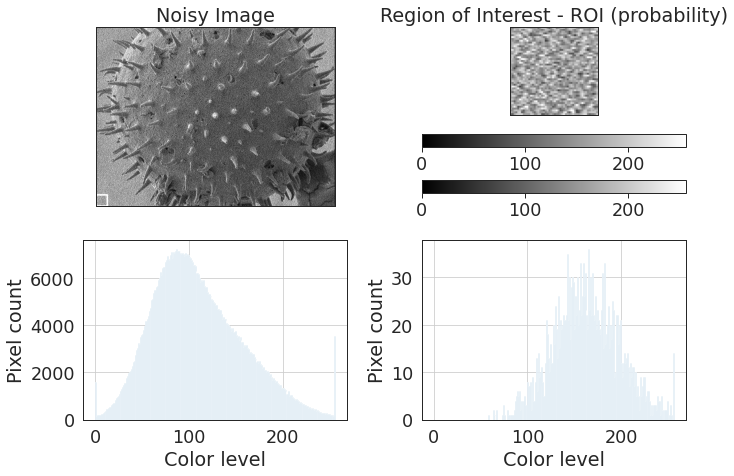

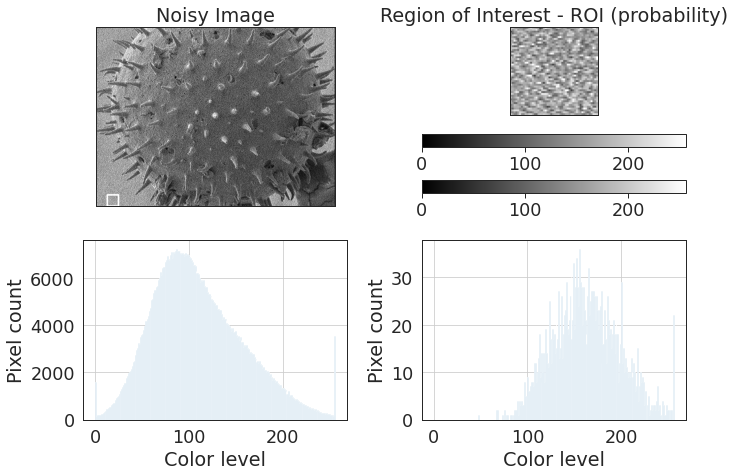

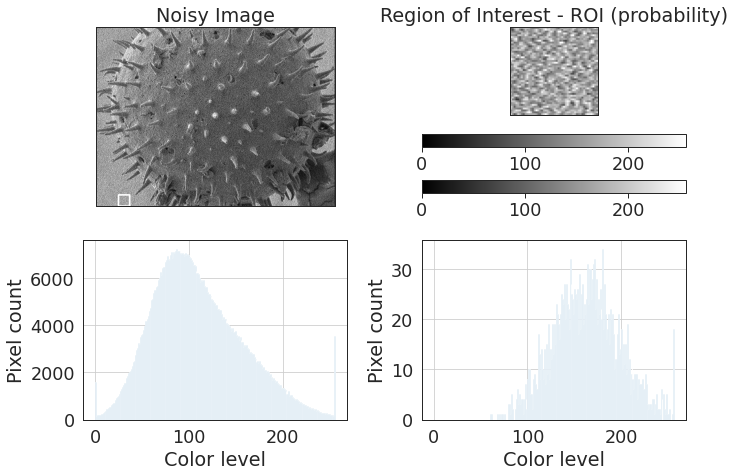

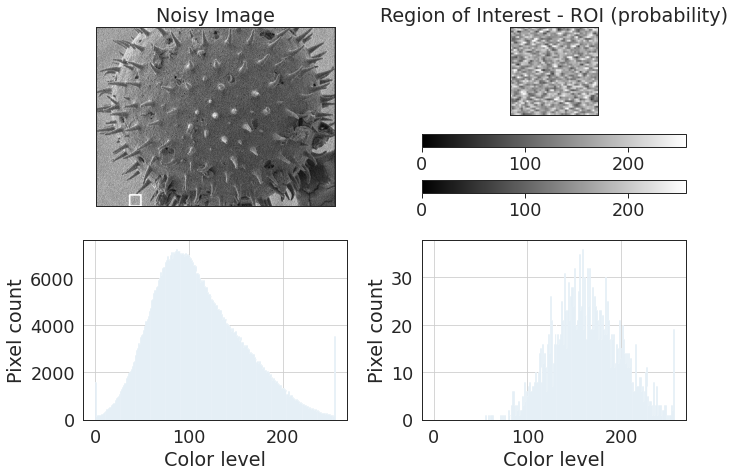

In [44]:
left,upper,right,lower, mean = tile('pollen.spd2.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd2.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd02.png')

In [45]:
data = smooth_parts[1][(smooth_parts[1] > 67) & (smooth_parts[1] < 247)].ravel()

In [48]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0.05
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 0.564
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data looks normal (fail to reject H0)
10.000: 0.655, data looks normal (fail to reject H0)
5.000: 0.786, data looks normal (fail to reject H0)
2.500: 0.916, data looks normal (fail to reject H0)
1.000: 1.090, data looks normal (fail to reject H0)


In [49]:
from scipy import stats
k2, p = stats.normaltest(data)
#print(p)
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.000681414
The null hypothesis can be rejected


In [50]:
pg.normality(data,method="jarque_bera")

W      pval  normal
0  10.411278  0.005486   False

(array([ 11.,  14.,  27.,  59.,  63., 116., 135., 175., 196., 255., 219.,
        248., 190., 145., 145.,  98.,  79.,  43.,  39.,  17.]),
 array([ 69.  ,  77.85,  86.7 ,  95.55, 104.4 , 113.25, 122.1 , 130.95,
        139.8 , 148.65, 157.5 , 166.35, 175.2 , 184.05, 192.9 , 201.75,
        210.6 , 219.45, 228.3 , 237.15, 246.  ]),
 <BarContainer object of 20 artists>)

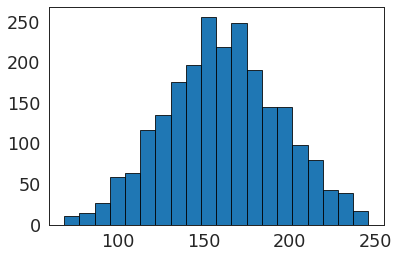

In [51]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(data, edgecolor='black', bins=20)

In [52]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(data)
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.000263388
The null hypothesis can be rejected


# Residual Calculation Test

In [53]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(data)
residialgauss

array([0.0087185 , 0.0087185 , 0.01640769, ..., 0.0087185 , 0.0255594 ,
       0.02943563])

In [54]:
meanpois, sigmapois, residialpois = computeresidualpoisson(data)
residialpois

array([0.1753935 , 0.2027225 , 0.00679189, ..., 0.14925333, 0.03652292,
       0.06681377])

In [55]:
type_noise = []
gauss = []
poi = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
        poi.append(residialpois[i])
    else:
        type_noise.append('gaussian')
        gauss.append(residialgauss[i])
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  861
Gaussian pixels :  1413


In [56]:
#!pip install poisson-etest

Fitting 5 distributions:  60%|████████████        | 3/5 [00:23<00:15,  7.97s/it]SKIPPED lognorm distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
Fitting 5 distributions: 100%|████████████████████| 5/5 [00:30<00:00,  6.20s/it]
lognorm was not fitted. no parameters available
burr was not fitted. no parameters available


sumsquare_error          aic           bic  kl_div  ks_statistic  \
gamma           0.000418  1125.636989 -3.524604e+04     inf      0.013230   
norm            0.000418  1123.465779 -3.525299e+04     inf      0.013132   
beta            0.000425  1125.225230 -3.519887e+04     inf      0.021740   
lognorm              inf          inf           inf     inf           NaN   
burr                 inf          inf           inf     inf           NaN   

         ks_pvalue  
gamma     0.815803  
norm      0.822759  
beta      0.229357  
lognorm        NaN  
burr           NaN

/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


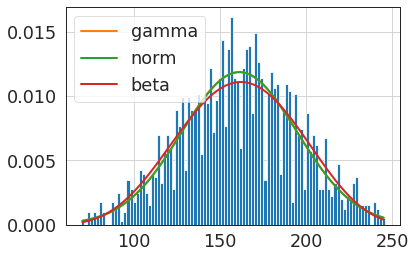

In [57]:
f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

Fitting 10 distributions: 100%|█████████████████| 10/10 [00:31<00:00,  3.12s/it]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
gamma            0.000418  1125.636989 -35246.038902     inf      0.013230   
norm             0.000418  1123.465779 -35252.990250     inf      0.013132   
rayleigh         0.000665          inf -34197.267705     inf      0.090348   
cauchy           0.000748  1156.012832 -33930.450983     inf      0.078616   
powerlaw         0.001755  1050.060806 -31982.095870     inf      0.204488   

             ks_pvalue  
gamma     8.158031e-01  
norm      8.227592e-01  
rayleigh  1.331343e-16  
cauchy    1.135021e-12  
powerlaw  7.437834e-84

/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


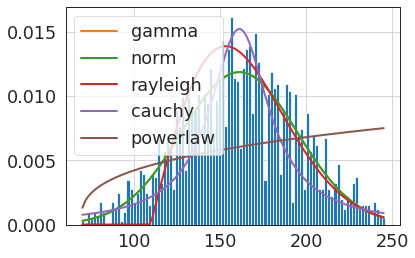

In [58]:
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

Fitting 106 distributions:  11%|█▋             | 12/106 [00:30<02:35,  1.65s/it]SKIPPED burr12 distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
Fitting 106 distributions:  30%|████▌          | 32/106 [01:00<01:58,  1.60s/it]SKIPPED gausshyper distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
Fitting 106 distributions:  49%|███████▎       | 52/106 [01:30<03:12,  3.56s/it]SKIPPED invgauss distribution (taking more than 30 seconds)
SKIPPED invweibull distribution (taking more than 30 seconds)
Fitting 106 distributions:  50%|███████▌       | 53/106 [01:30<02:27,  2.78s/it]SKIPPED johnsonsb distribution (taking more than 30 seconds)
SKIPPED johnsonsu distribution (taking more than 30 seconds)
Fitting 106 distributions:  72%|██████████▊    | 76/106 [02:01<00:59,  1.98s/it]SKIPPED nakagami distribution (taking more than 30 seconds)
SKIPPED ncf distribution (taking more than 30 seconds)
Fitti

sumsquare_error          aic           bic  kl_div  \
powernorm             0.000418  1125.667909 -35246.460450     inf   
genhyperbolic         0.000418  1130.040703 -35230.644684     inf   
erlang                0.000418  1125.638151 -35246.042675     inf   
norm                  0.000418  1123.465779 -35252.990250     inf   
gennorm               0.000424  1126.004231 -35210.428318     inf   

               ks_statistic  ks_pvalue  
powernorm          0.013154   0.821207  
genhyperbolic      0.013711   0.780644  
erlang             0.013217   0.816726  
norm               0.013132   0.822759  
gennorm            0.019163   0.369268

/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


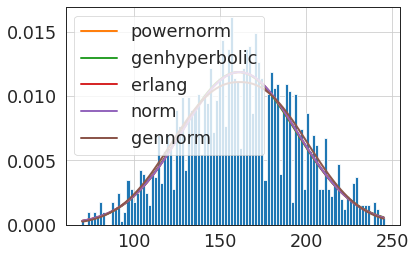

In [59]:
f = Fitter(data,
           distributions= get_distributions())
f.fit()
f.summary()

# Segmentation and Noise Estimation Scan speed 03

48


/tmp/ipykernel_8874/1017964780.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221),plt.imshow(image,cmap = 'gray')


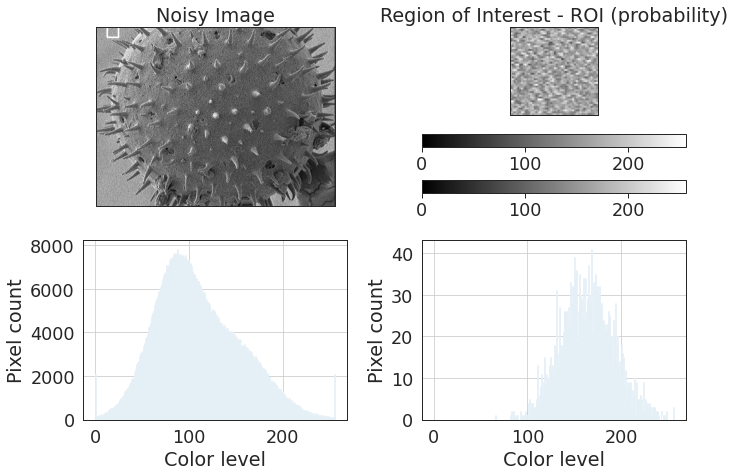

/home/deepvision/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


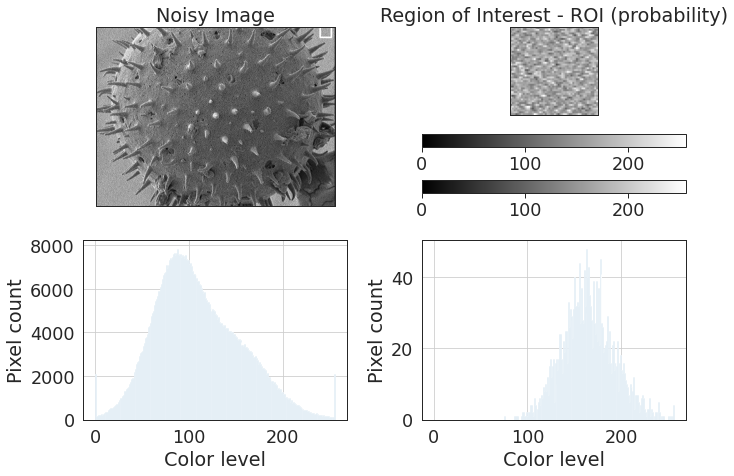

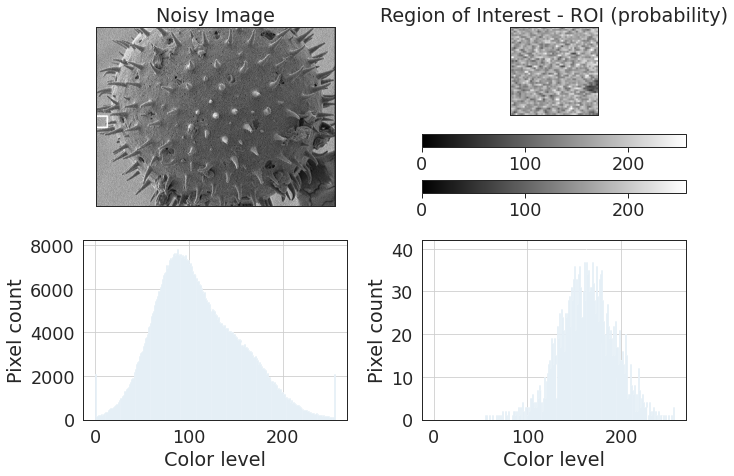

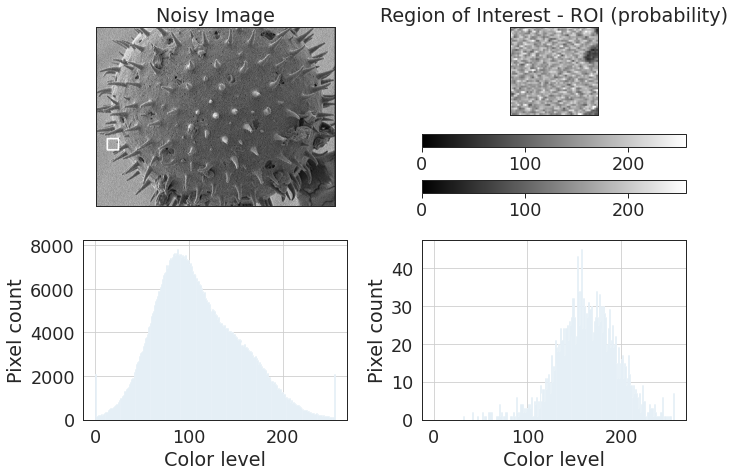

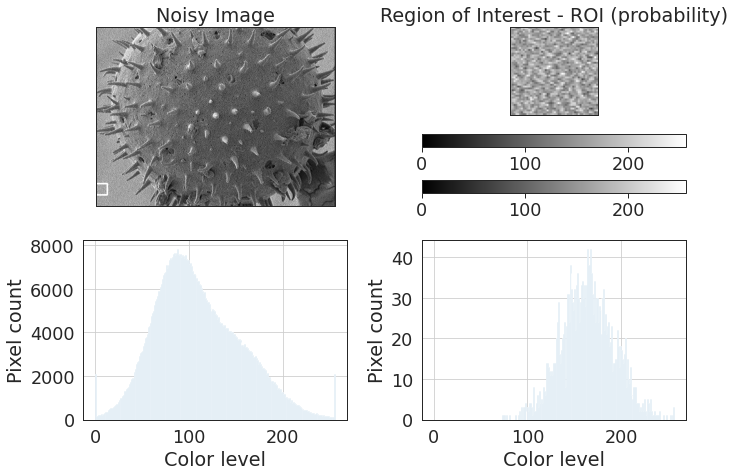

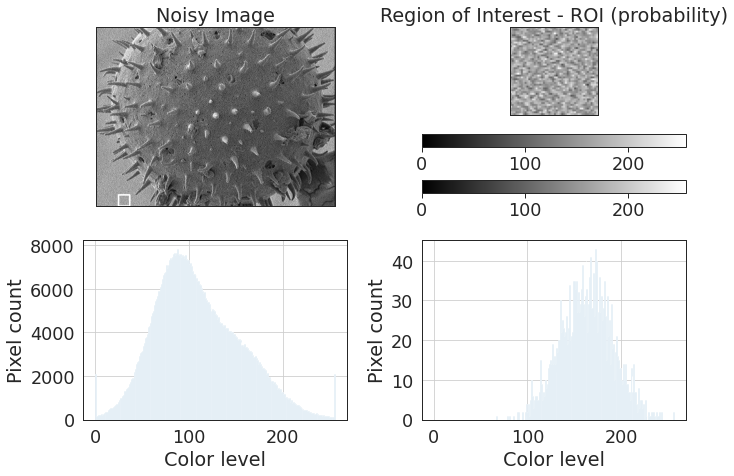

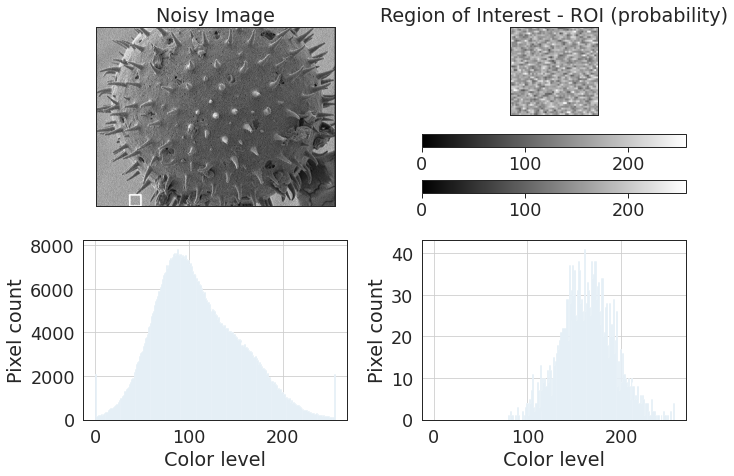

In [60]:
left,upper,right,lower, mean = tile('pollen.spd3.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd3.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd03.png')

In [61]:
data = smooth_parts[5][(smooth_parts[5] > 67) & (smooth_parts[5] < 247)].ravel()

In [62]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 0.466
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data looks normal (fail to reject H0)
10.000: 0.655, data looks normal (fail to reject H0)
5.000: 0.786, data looks normal (fail to reject H0)
2.500: 0.916, data looks normal (fail to reject H0)
1.000: 1.090, data looks normal (fail to reject H0)


In [63]:
from scipy import stats
k2, p = stats.normaltest(data)
#print(p)
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.0435651
The null hypothesis can be rejected


W      pval  normal
0  5.188994  0.074683    True

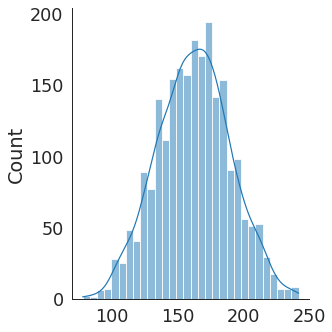

In [64]:
sns.displot(data, kde=True)
pg.normality(data,method="jarque_bera")

(array([  3.,   6.,  14.,  46.,  61., 116., 147., 181., 222., 251., 286.,
        259., 217., 167., 121.,  84.,  65.,  33.,  11.,  11.]),
 array([ 78. ,  86.2,  94.4, 102.6, 110.8, 119. , 127.2, 135.4, 143.6,
        151.8, 160. , 168.2, 176.4, 184.6, 192.8, 201. , 209.2, 217.4,
        225.6, 233.8, 242. ]),
 <BarContainer object of 20 artists>)

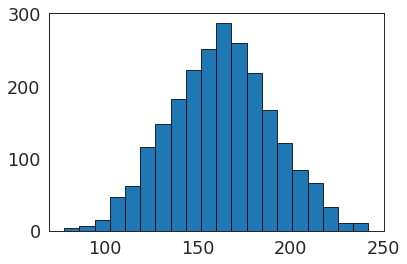

In [65]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(data, edgecolor='black', bins=20)

In [66]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(data)
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.0456527
The null hypothesis cannot be rejected


# Residual Calculation Test

In [67]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(data)
residialgauss

array([0.01054225, 0.01054225, 0.01054225, ..., 0.01054225, 0.06091236,
       0.00773084])

In [68]:
meanpois, sigmapois, residialpois = computeresidualpoisson(data)
residialpois

array([0.17661594, 0.0089147 , 0.00731732, ..., 0.00920239, 0.17668167,
       0.00789067])

In [69]:
type_noise = []
gauss = []
poi = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
        poi.append(residialpois[i])
    else:
        type_noise.append('gaussian')
        gauss.append(residialgauss[i])
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  991
Gaussian pixels :  1310


In [70]:
print(np.mean(gauss))
print(np.mean(poi))

0.025222225281320385
0.009947300390248557


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:31<00:00,  6.30s/it]
lognorm was not fitted. no parameters available
burr was not fitted. no parameters available
gamma was not fitted. no parameters available


sumsquare_error          aic           bic  kl_div  ks_statistic  \
norm            0.000791  1146.611561 -3.423213e+04     inf      0.015321   
beta            0.000793  1157.631976 -3.420909e+04     inf      0.016841   
lognorm              inf          inf           inf     inf           NaN   
burr                 inf          inf           inf     inf           NaN   
gamma                inf          inf           inf     inf           NaN   

         ks_pvalue  
norm      0.646739  
beta      0.525917  
lognorm        NaN  
burr           NaN  
gamma          NaN

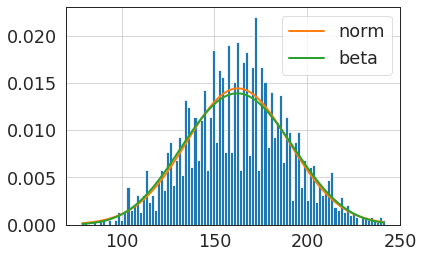

In [71]:
f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

Fitting 10 distributions:  80%|██████████████▍   | 8/10 [00:30<00:08,  4.25s/it]SKIPPED gamma distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitting 10 distributions: 100%|█████████████████| 10/10 [00:31<00:00,  3.14s/it]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
norm             0.000791  1146.611561 -34232.128961     inf      0.015321   
cauchy           0.001257  1150.359014 -33165.357742     inf      0.078619   
rayleigh         0.001481          inf -32787.193842     inf      0.140688   
powerlaw         0.003103  1036.834296 -31078.299097     inf      0.254581   
uniform          0.003233  1023.973286 -30991.218797     inf      0.200523   

              ks_pvalue  
norm       6.467389e-01  
cauchy     8.107492e-13  
rayleigh   3.383309e-40  
powerlaw  5.920288e-132  
uniform    1.422376e-81

/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


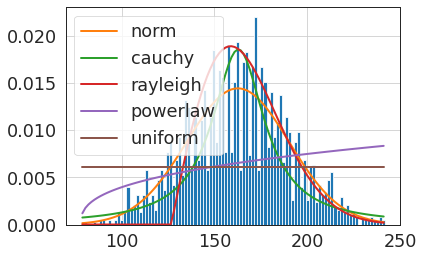

In [72]:
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

Fitting 106 distributions:  11%|█▋             | 12/106 [00:31<03:00,  1.92s/it]SKIPPED betaprime distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
Fitting 106 distributions:  13%|█▉             | 14/106 [00:31<01:39,  1.08s/it]SKIPPED chi2 distribution (taking more than 30 seconds)
SKIPPED chi distribution (taking more than 30 seconds)
Fitting 106 distributions:  18%|██▋            | 19/106 [00:36<02:09,  1.49s/it]SKIPPED exponpow distribution (taking more than 30 seconds)
SKIPPED exponweib distribution (taking more than 30 seconds)
Fitting 106 distributions:  31%|████▋          | 33/106 [01:01<01:06,  1.09it/s]SKIPPED genextreme distribution (taking more than 30 seconds)
SKIPPED gengamma distribution (taking more than 30 seconds)
Fitting 106 distributions:  52%|███████▊       | 55/106 [01:31<00:50,  1.00it/s]SKIPPED johnsonsu distribution (taking more than 30 seconds)
SKIPPED kappa4 distribution (taking more than 30 seconds)
Fitting 10

sumsquare_error          aic           bic  kl_div  ks_statistic  \
norm              0.000791  1146.611561 -34232.128961     inf      0.015321   
exponnorm         0.000791  1148.633059 -34224.288077     inf      0.015407   
powernorm         0.000792  1149.782887 -34220.085484     inf      0.018080   
beta              0.000793  1157.631976 -34209.085287     inf      0.016841   
gennorm           0.000793  1153.019740 -34216.824079     inf      0.015842   

           ks_pvalue  
norm        0.646739  
exponnorm   0.639818  
powernorm   0.434390  
beta        0.525917  
gennorm     0.604755

/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/deepvision/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


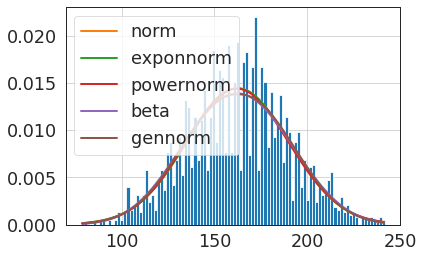

In [73]:
f = Fitter(data,
           distributions= get_distributions())
f.fit()
f.summary()

# Segmentation and Noise Estimation Scan speed 05

48


/tmp/ipykernel_8874/1017964780.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221),plt.imshow(image,cmap = 'gray')


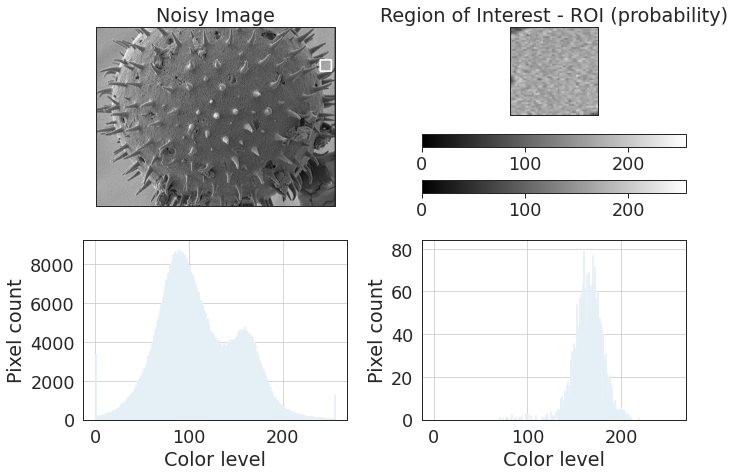

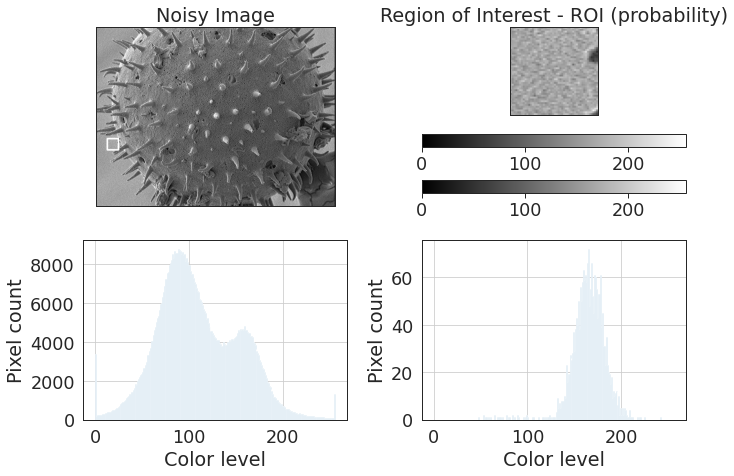

In [ ]:
left,upper,right,lower, mean = tile('pollen.spd5.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd5.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd05.png')

In [ ]:
data = smooth_parts[2][(smooth_parts[2] > 67) & (smooth_parts[2] < 247)].ravel()

In [ ]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0.05
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

In [ ]:
sns.displot(data, kde=True)
pg.normality(data,method="jarque_bera")

In [ ]:
from scipy import stats
k2, p = stats.normaltest(data)
#print(p)
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(data, edgecolor='black', bins=20)

In [ ]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(data)
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

# Residual Calculation Test

In [374]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(data)
residialgauss

array([0.09898299, 0.09898299, 0.09898299, ..., 0.02092451, 0.02092451,
       0.02092451])

In [375]:
meanpois, sigmapois, residialpois = computeresidualpoisson(data)
residialpois

array([0.09071649, 0.09071649, 0.09071649, ..., 0.04563138, 0.10048094,
       0.12845146])

In [376]:
type_noise = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
    else:
        type_noise.append('gaussian')
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  1057
Gaussian pixels :  1247


In [ ]:
f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [ ]:
f = Fitter(data,
           distributions= get_distributions())
f.fit()
f.summary()

# Segmentation and Noise Estimation Scan speed 08

48


/tmp/ipykernel_2240/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_2240/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


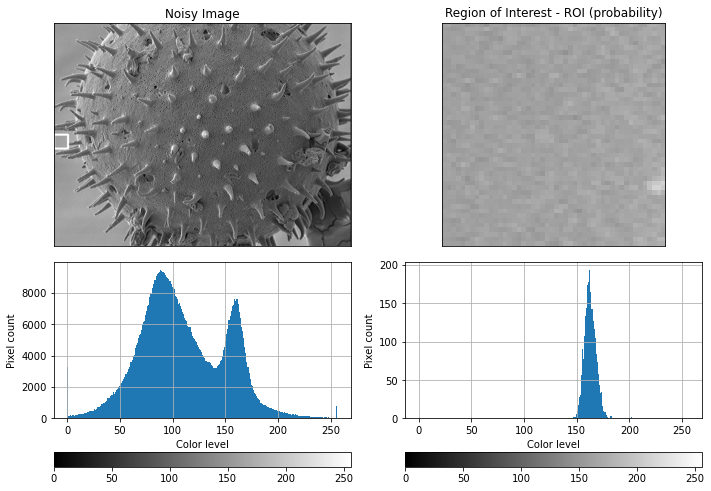

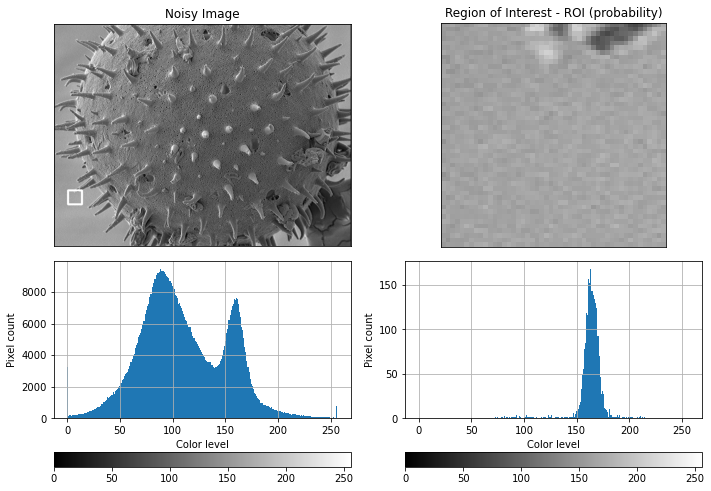

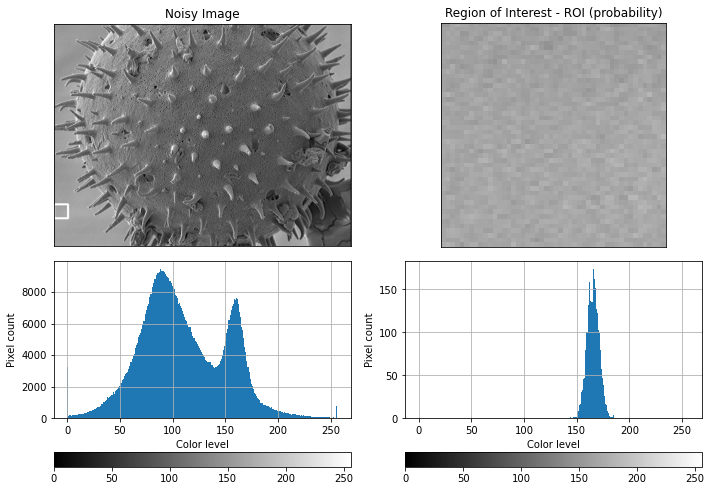

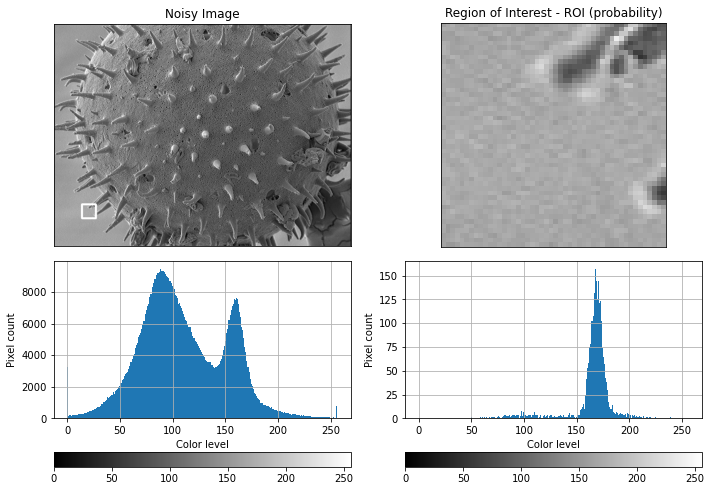

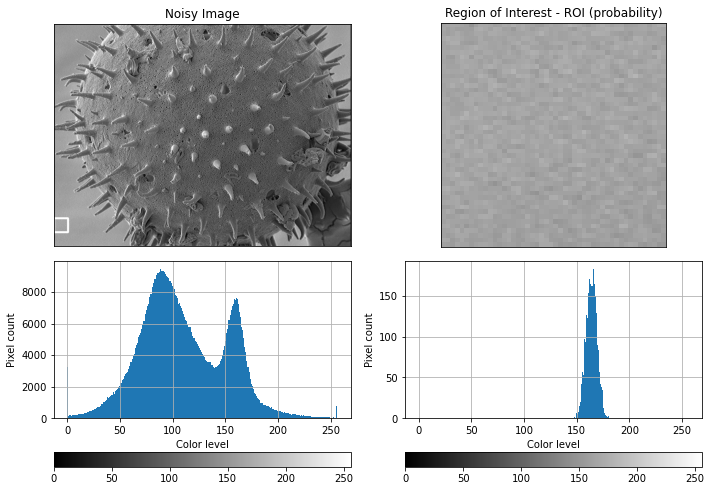

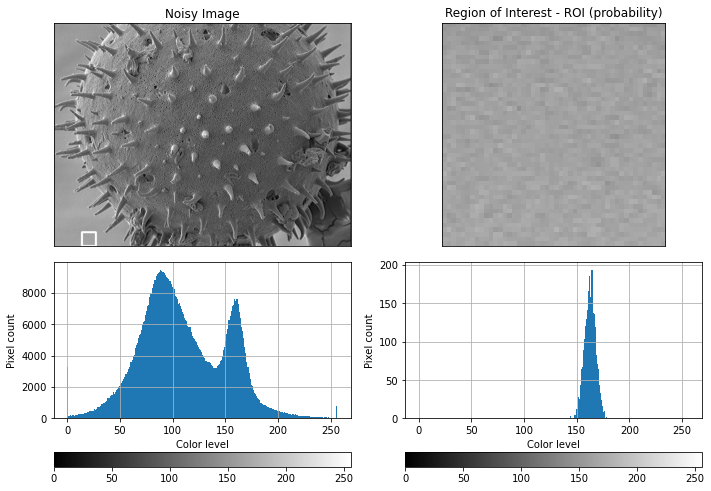

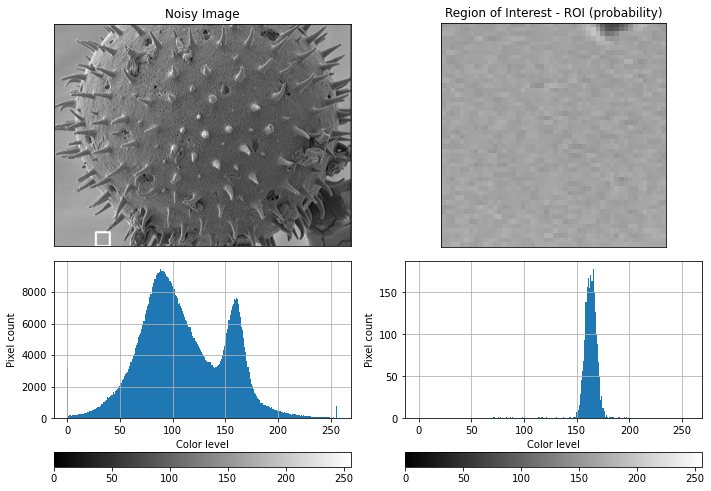

In [377]:
left,upper,right,lower, mean = tile('pollen.spd8.0098.png','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/pollen.spd8.0098.png',left_select,upper_select,right_select,lower_select,'manual_noise/spd08.png')

In [378]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[4].ravel())
#print(p)
alpha = 1e-3
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.653993
The null hypothesis cannot be rejected


In [379]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[4].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 3.688
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


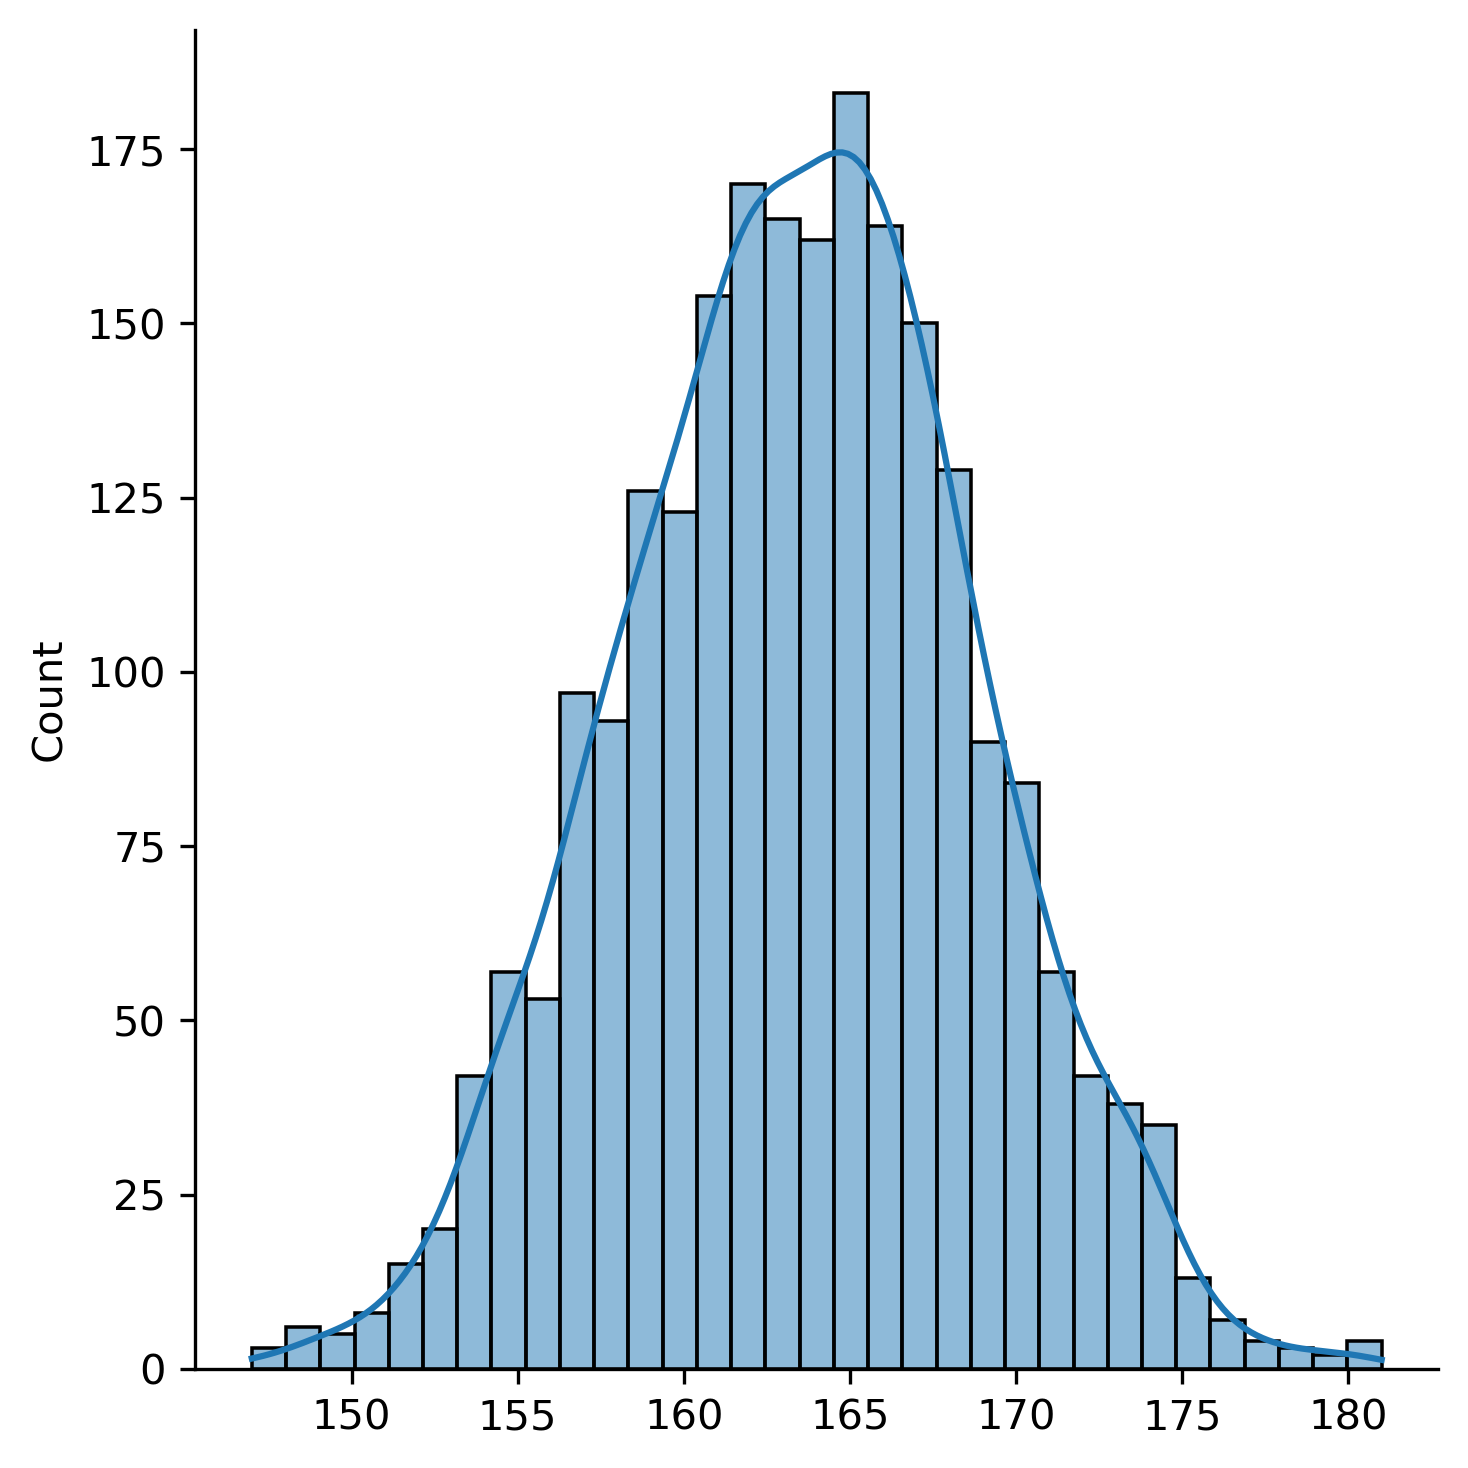

In [380]:
p = sns.displot(smooth_parts[4].ravel(), kde=True)
p.fig.set_dpi(300)
plt.savefig('manual_noise/validation/hist_scan_speed_08.png', dpi=300)


W      pval  normal
0  0.894047  0.639529    True

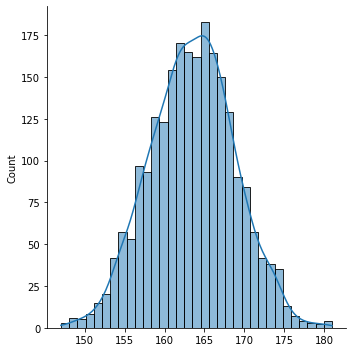

In [381]:
sns.displot(smooth_parts[4].ravel(), kde=True)
pg.normality(smooth_parts[4].ravel(),method="jarque_bera")

(array([  3.,  11.,  23.,  20.,  99., 150.,  93., 249., 324., 165., 345.,
        314., 219.,  84.,  99.,  73.,  13.,  11.,   5.,   4.]),
 array([147. , 148.7, 150.4, 152.1, 153.8, 155.5, 157.2, 158.9, 160.6,
        162.3, 164. , 165.7, 167.4, 169.1, 170.8, 172.5, 174.2, 175.9,
        177.6, 179.3, 181. ]),
 <BarContainer object of 20 artists>)

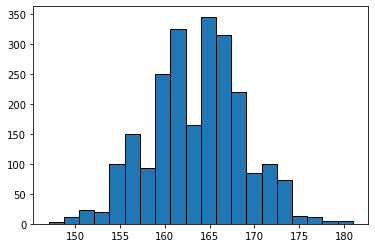

In [382]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[4].ravel(), edgecolor='black', bins=20)

In [383]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[4].ravel())
alpha = 0.05
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.13204e-05
The null hypothesis can be rejected


# Residual Calculation Test

In [384]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[4].ravel())
residialgauss

array([0.05394189, 1.4911792 , 1.26926255, ..., 0.05394189, 0.05394189,
       0.05394189])

In [385]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[4].ravel())
residialpois

array([0.23307436, 0.23564469, 0.22809535, ..., 0.21125948, 0.0971365 ,
       0.12018256])

In [386]:
type_noise = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
    else:
        type_noise.append('gaussian')
print(type_noise.count('poison'))
print(type_noise.count('gaussian'))

899
1405


# Segmentation and Noise Estimation dwell time 25ns

48


/tmp/ipykernel_2240/1017964780.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')
/tmp/ipykernel_2240/1017964780.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='horizontal')


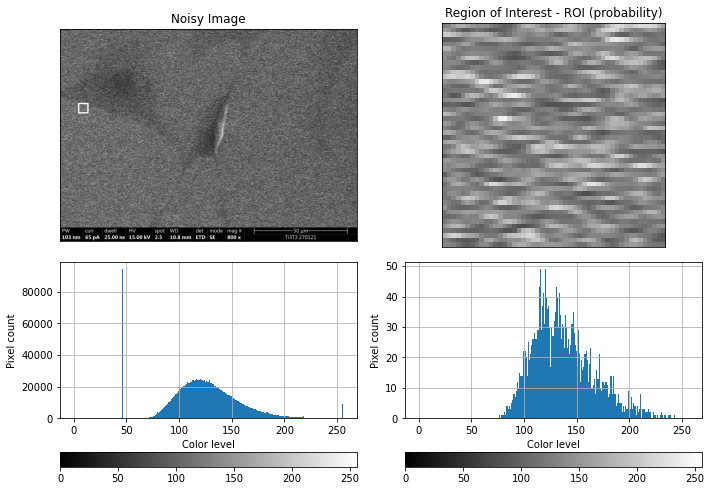

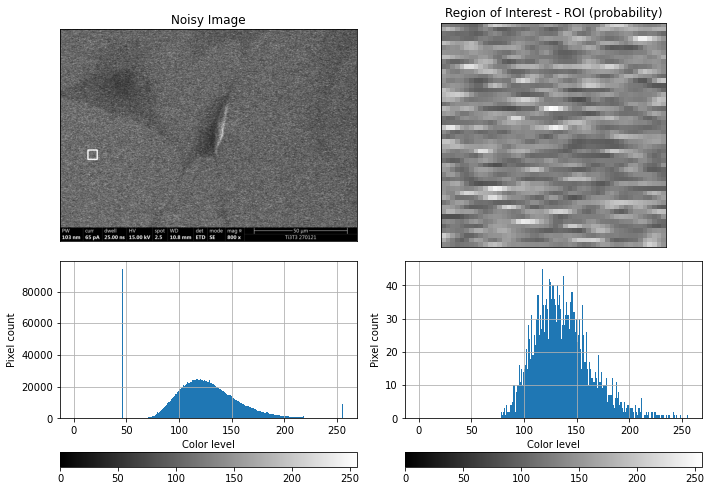

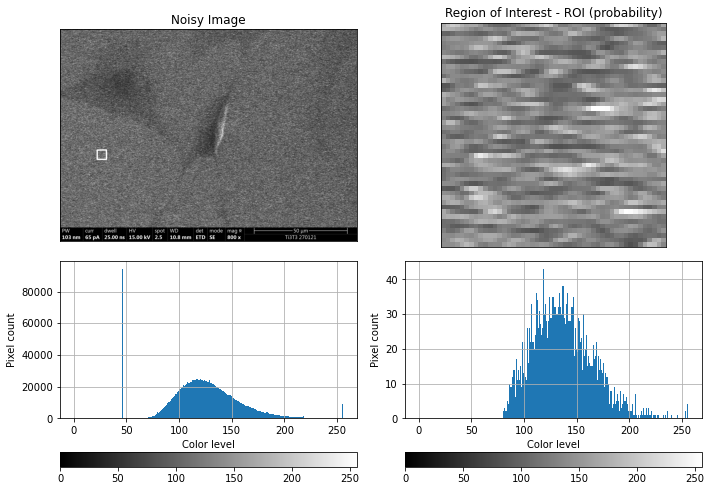

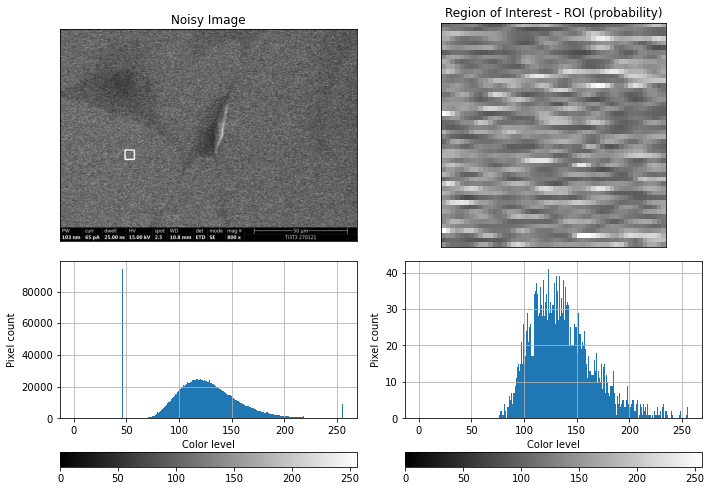

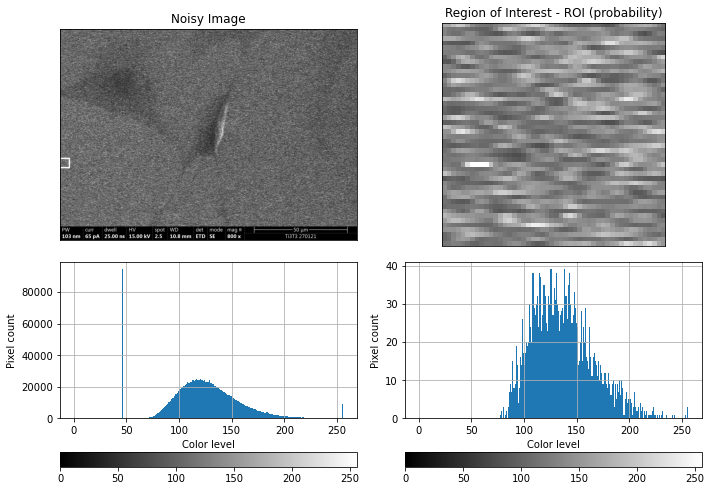

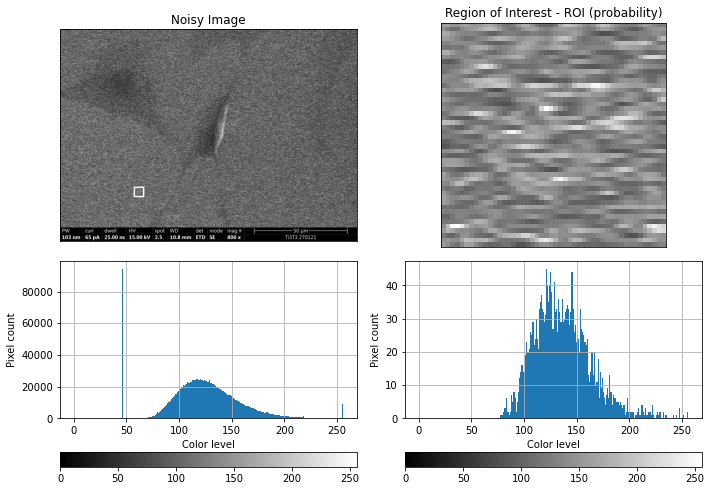

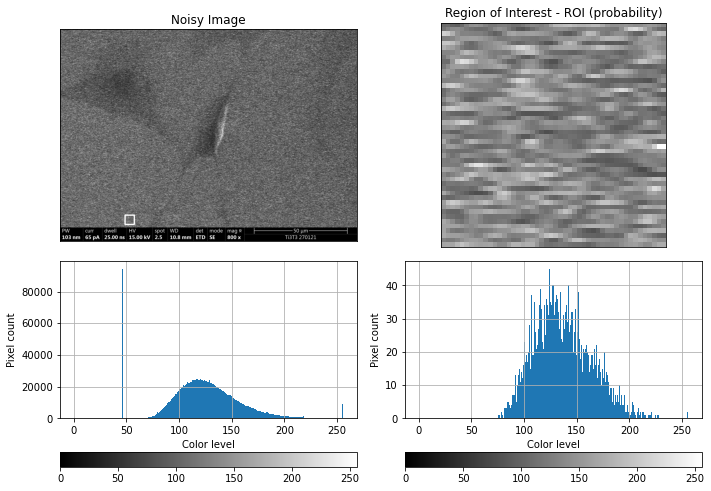

In [187]:
left,upper,right,lower, mean = tile('20210127-Ti3T3-25.00ns-2.5-008.tif','SEM','out')
left_select,upper_select,right_select,lower_select = selectROI(left,upper,right,lower, mean)
smooth_parts = visualize_the_ROI('SEM/20210127-Ti3T3-25.00ns-2.5-008.tif',left_select,upper_select,right_select,lower_select,'manual_noise/semdjon_25ns.png')

In [212]:
from scipy import stats
k2, p = stats.normaltest(smooth_parts[3].ravel())
#print(p)
alpha = 1e-3
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 3.13304e-54
The null hypothesis can be rejected


W  pval  normal
0  337.344156   0.0   False

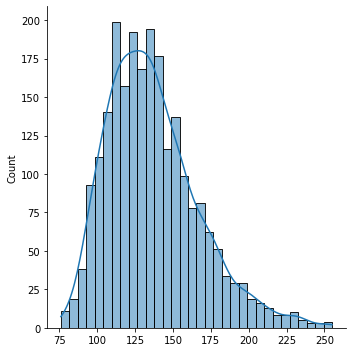

In [211]:
sns.displot(smooth_parts[3].ravel(), kde=True)
pg.normality(smooth_parts[3].ravel(),method="jarque_bera")

In [213]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(smooth_parts[3].ravel())
print('Statistic: %.3f' % result.statistic)
p = 0
print(result.critical_values)
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 21.664
[0.575 0.655 0.786 0.916 1.09 ]
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


(array([ 16.,  66., 161., 241., 284., 286., 295., 241., 203., 136., 114.,
         89.,  49.,  41.,  28.,  20.,  10.,  14.,   3.,   7.]),
 array([ 76.  ,  84.95,  93.9 , 102.85, 111.8 , 120.75, 129.7 , 138.65,
        147.6 , 156.55, 165.5 , 174.45, 183.4 , 192.35, 201.3 , 210.25,
        219.2 , 228.15, 237.1 , 246.05, 255.  ]),
 <BarContainer object of 20 artists>)

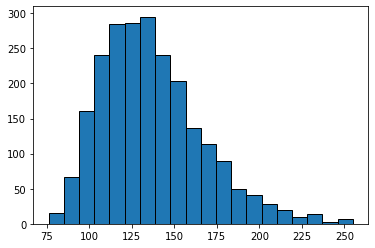

In [214]:
# Visual method
#make this example reproducible
np.random.seed(1)

#create histogram to visualize values in dataset
plt.hist(smooth_parts[3].ravel(), edgecolor='black', bins=20)

In [215]:
#Perform a Shapiro-Wilk Test

#make this example reproducible
np.random.seed(1)


#perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(smooth_parts[3].ravel())
alpha = 0.001
print("p = {:g}".format(p))
#p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 3.07834e-25
The null hypothesis can be rejected


# Residual Calculation Test

In [216]:
meangauss, sigmagauss, residialgauss = computeresidualgaussian(smooth_parts[3].ravel())
residialgauss

array([0.01050031, 0.01050031, 0.01050031, ..., 0.00772817, 0.00935506,
       0.03551075])

In [217]:
meanpois, sigmapois, residialpois = computeresidualpoisson(smooth_parts[3].ravel())
residialpois

array([0.06118148, 0.07718925, 0.20229982, ..., 0.0104858 , 0.00863394,
       0.04212081])

In [218]:
type_noise = []
for i in range(0,len(residialgauss)):
    #for j in residialpois:
    if (residialgauss[i] - 0) > (residialpois[i]-0):
        type_noise.append('poison')
    else:
        type_noise.append('gaussian')
print('Poison pixels : ', str(type_noise.count('poison')))
print('Gaussian pixels : ', str(type_noise.count('gaussian')))

Poison pixels :  683
Gaussian pixels :  1621
